In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
from pycocotools.coco import COCO
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from math import ceil

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
epochs = 25
batch_size = 128


path_to_train_image = "D:\\Studies\\ucenje\\keypoint_detection_coco\\data\\train2017\\"
path_to_train_anns = "D:\\Studies\\ucenje\\keypoint_detection_coco\\data\\annotations\\coco_wholebody_train_v1.0.json"
path_to_val_image = "D:\\Studies\\ucenje\\keypoint_detection_coco\\data\\val2017\\"
path_to_val_anns = "D:\\Studies\\ucenje\\keypoint_detection_coco\\data\\annotations\\coco_wholebody_val_v1.0.json"

# Prepare data

In [3]:
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_images, path_to_anns):
        super(CocoDataset, self).__init__()
        coco = COCO(path_to_anns)
        self.anns = coco.loadAnns(coco.getAnnIds(imgIds=coco.getImgIds(catIds=[1]), catIds=[1]))
        self.path_to_images = path_to_images

        # Loading data from annotations and cleaning it to make a simple dataset
        all_entries = [[self.anns[i]["keypoints"][j] for j in range(len(self.anns[i]["keypoints"])) if j % 3 != 0] for i in range(len(self.anns))]
        for i in range(len(self.anns)):
            all_entries[i].append(self.anns[i]['image_id'])

        columns = np.array([
            "nose",
            "left_eye",
            "right_eye",
            "left_ear",
            "right_ear",
            "left_shoulder",
            "right_shoulder",
            "left_elbow",
            "right_elbow",
            "left_wrist",
            "right_wrist",
            "left_hip",
            "right_hip",
            "left_knee",
            "right_knee",
            "left_ankle",
            "right_ankle"
        ])

        columns = [x for pair in zip(columns, columns) for x in pair]
        for i in range(len(columns)):
            if i % 2 == 0:
                columns[i] = columns[i] + '.x'
            else:
                columns[i] = columns[i] + '.y'

        columns = columns + ["id"]
        all_entries_df = pd.DataFrame(all_entries, columns=columns)
        self.data = all_entries_df[~(all_entries_df == 0).any(axis=1)].drop_duplicates(subset=["id"])
        # 6830 rows x 35 columns, (x,y) of specific keypoint * 17, id of image
        # every image has one person on it

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_id = str(self.data.id.iloc[index]).zfill(12) + '.jpg'
        image = Image.open(self.path_to_images + image_id).convert("RGB")
        original_width, original_height = image.size
        image = np.asarray(image.resize((200, 200)), dtype="float32")
        image = image / 255.
        image = image.transpose(2, 0, 1)
        keypoints = self.data.iloc[index][:34]
        keypoints = np.array(keypoints, dtype="float32")
        keypoints = keypoints.reshape(-1, 2)
        keypoints = keypoints * [200 / original_width, 200 / original_height]
        return {
            "image": torch.tensor(image, dtype=torch.float32),
            "keypoints": torch.tensor(keypoints, dtype=torch.float32)
        }


train_data = CocoDataset(path_to_train_image, path_to_train_anns)
val_data = CocoDataset(path_to_val_image, path_to_val_anns)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

loading annotations into memory...
Done (t=47.17s)
creating index...
index created!
loading annotations into memory...
Done (t=1.57s)
creating index...
index created!


# Create model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 7)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.linear1 = nn.LazyLinear(4096)
        self.linear2 = nn.Linear(4096, 1000)
        self.linear3 = nn.Linear(1000, 512)
        self.linear4 = nn.Linear(512, 100)
        self.linear5 = nn.Linear(100, 34)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = self.linear5(x)
        return x

# Train loop

In [5]:
torch.cuda.empty_cache()
model = SimpleCNN().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

train_loss = []
val_loss = []
for epoch in range(epochs):
    train_running_loss = 0.0
    val_running_loss = 0.0
    model.train()
    for i, data in tqdm(enumerate(train_loader)):
        image, keypoints = data['image'].to(device), data["keypoints"].to(device)
        keypoints = keypoints.view(keypoints.size(0), -1)
        preds = model(image)
        loss = criterion(preds, keypoints)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_running_loss += loss.item()
    train_loss.append(train_running_loss / (ceil(len(train_loader) / batch_size)))

    torch.cuda.empty_cache()
    model.eval()

    with torch.no_grad():
        val_running_loss = 0.0
        for i, data in tqdm(enumerate(val_loader)):
            image, keypoints = data['image'].to(device), data['keypoints'].to(device)
            keypoints = keypoints.view(keypoints.size(0), -1)
            preds = model(image)
            loss = criterion(preds, keypoints)
            val_running_loss += loss.item()
        val_loss.append(val_running_loss / (ceil(len(val_loader) / batch_size)))
    print(f'Epoch {epoch + 1}')


C:\Users\user\anaconda3\envs\pytorch_tutorial\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
54it [01:07,  1.25s/it]
3it [00:02,  1.36it/s]


Epoch 1


54it [01:01,  1.15s/it]
3it [00:02,  1.36it/s]


Epoch 2


54it [01:03,  1.17s/it]
3it [00:02,  1.42it/s]


Epoch 3


54it [01:00,  1.11s/it]
3it [00:02,  1.37it/s]


Epoch 4


54it [00:59,  1.10s/it]
3it [00:02,  1.48it/s]


Epoch 5


54it [00:59,  1.11s/it]
3it [00:02,  1.49it/s]


Epoch 6


54it [00:59,  1.10s/it]
3it [00:02,  1.40it/s]


Epoch 7


54it [00:59,  1.10s/it]
3it [00:02,  1.50it/s]


Epoch 8


54it [00:59,  1.10s/it]
3it [00:02,  1.46it/s]


Epoch 9


54it [00:58,  1.09s/it]
3it [00:02,  1.47it/s]


Epoch 10


54it [00:59,  1.10s/it]
3it [00:02,  1.48it/s]


Epoch 11


54it [00:58,  1.09s/it]
3it [00:02,  1.40it/s]


Epoch 12


54it [00:59,  1.09s/it]
3it [00:02,  1.47it/s]


Epoch 13


54it [00:59,  1.09s/it]
3it [00:02,  1.44it/s]


Epoch 14


54it [00:58,  1.09s/it]
3it [00:02,  1.46it/s]


Epoch 15


54it [00:58,  1.09s/it]
3it [00:02,  1.48it/s]


Epoch 16


54it [01:00,  1.13s/it]
3it [00:02,  1.38it/s]


Epoch 17


54it [00:59,  1.10s/it]
3it [00:01,  1.50it/s]


Epoch 18


54it [00:59,  1.09s/it]
3it [00:02,  1.45it/s]


Epoch 19


54it [00:58,  1.09s/it]
3it [00:02,  1.48it/s]


Epoch 20


54it [00:59,  1.10s/it]
3it [00:02,  1.48it/s]


Epoch 21


54it [00:58,  1.09s/it]
3it [00:02,  1.45it/s]


Epoch 22


54it [00:58,  1.09s/it]
3it [00:01,  1.52it/s]


Epoch 23


54it [00:58,  1.09s/it]
3it [00:02,  1.40it/s]


Epoch 24


54it [01:00,  1.12s/it]
3it [00:02,  1.41it/s]

Epoch 25


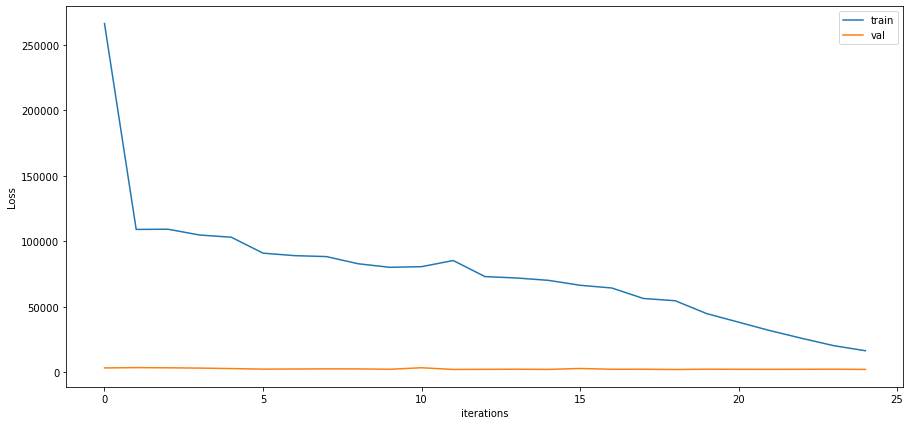

In [7]:
plt.figure(figsize=(15,7))
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [8]:
# Todo